Original NoteBook:

https://www.kaggle.com/code/vishalpainjane/drw-ensemble-0-72837

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drw-crypto-market-prediction/sample_submission.csv
/kaggle/input/drw-crypto-market-prediction/train.parquet
/kaggle/input/drw-crypto-market-prediction/test.parquet
/kaggle/input/the-order-of-the-test-rows-2/__results__.html
/kaggle/input/the-order-of-the-test-rows-2/__notebook__.ipynb
/kaggle/input/the-order-of-the-test-rows-2/closest_rows.csv
/kaggle/input/the-order-of-the-test-rows-2/__output__.json
/kaggle/input/the-order-of-the-test-rows-2/custom.css
/kaggle/input/the-order-of-the-test-rows-2/__results___files/__results___12_1.png
/kaggle/input/the-order-of-the-test-rows-2/__results___files/__results___5_1.png
/kaggle/input/the-order-of-the-test-rows-2/__results___files/__results___11_1.png


Loading training data...

Total columns in training data: 786
Sample columns: ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15']

Optimizing memory for raw training data...
Memory usage before optimization: 3157.59 MB
Memory usage after optimization: 1580.80 MB
Decreased by 49.9%

First pass: Basic preprocessing to identify top features...
Using 82 features out of 82 requested
Memory usage before optimization: 168.51 MB
Memory usage after optimization: 168.51 MB
Decreased by 0.0%
Creating lagged features in chunks...
  Processing lags: [1, 3, 5, 6, 7, 8, 9, 12, 15, 18]
  Processing lags: [20, 30, 120, 150, 365]
Memory usage before optimization: 2636.01 MB
Memory usage after optimization: 2636.01 MB
Decreased by 0.0%
Final feature count: 1312

Top features identified: ['X198_lead_30', 'X179_lead_120', 'X197_lead_30', 'X173_lead_120', 'X179_lead_150', 'X198', 'X40', 'X445_lead_30', 'X175_

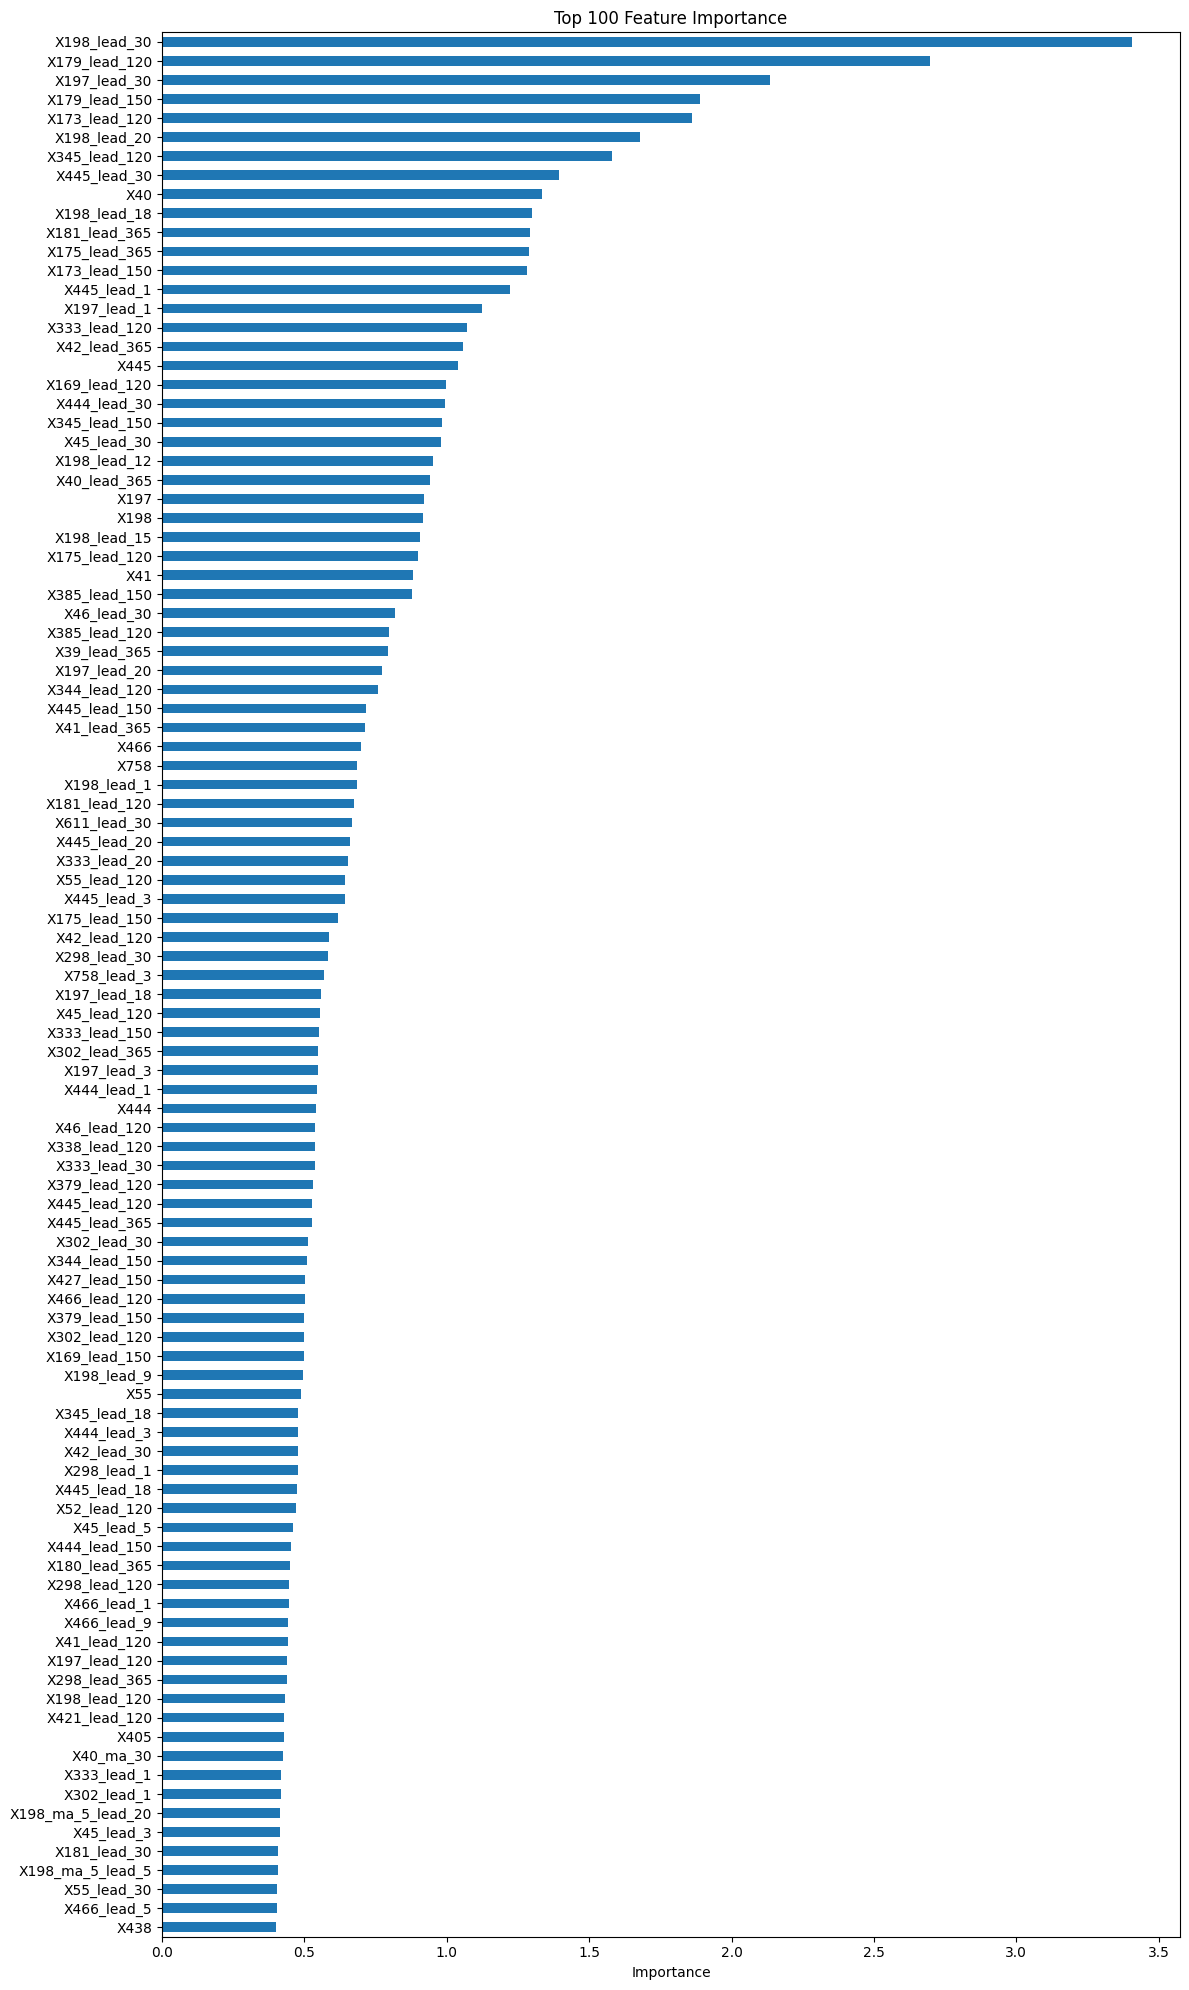


Top 20 most important features:
 1. X198_lead_30                             3.404790
 2. X179_lead_120                            2.696880
 3. X197_lead_30                             2.135876
 4. X179_lead_150                            1.890446
 5. X173_lead_120                            1.861391
 6. X198_lead_20                             1.677929
 7. X345_lead_120                            1.578500
 8. X445_lead_30                             1.395091
 9. X40                                      1.333037
10. X198_lead_18                             1.300426
11. X181_lead_365                            1.290907
12. X175_lead_365                            1.288595
13. X173_lead_150                            1.282700
14. X445_lead_1                              1.221124
15. X197_lead_1                              1.124194
16. X333_lead_120                            1.069489
17. X42_lead_365                             1.057987
18. X445                                     1.03

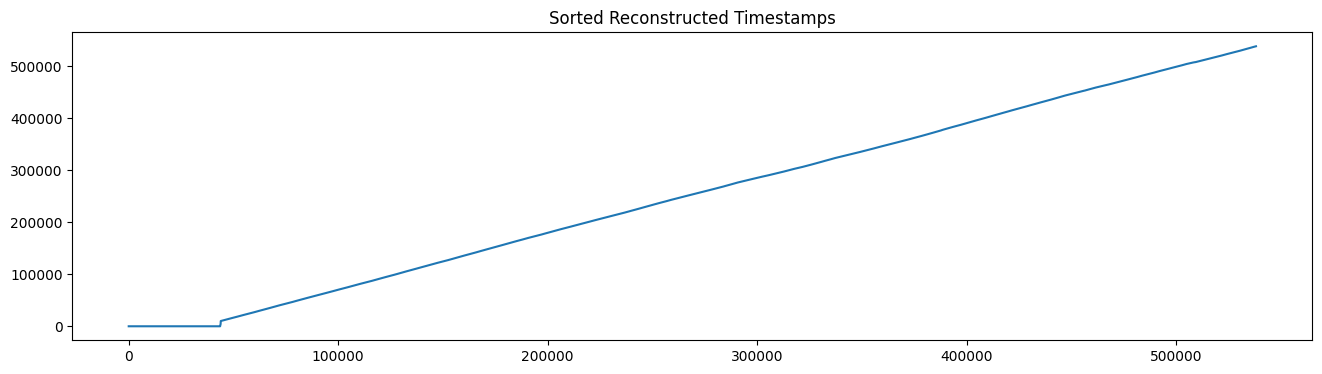

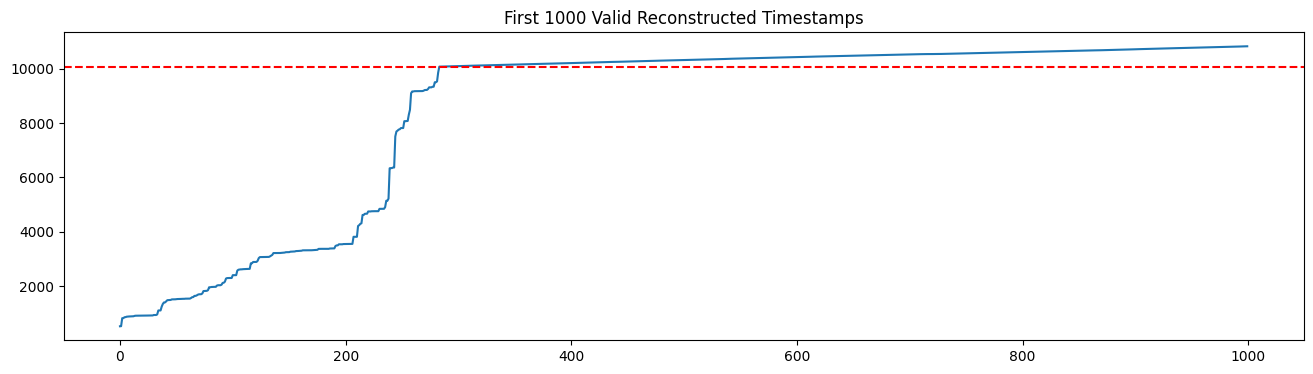

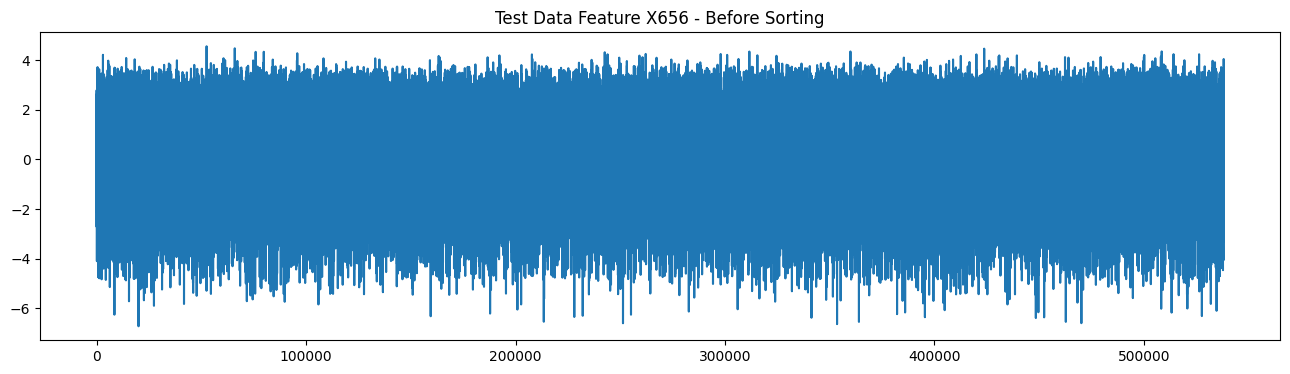

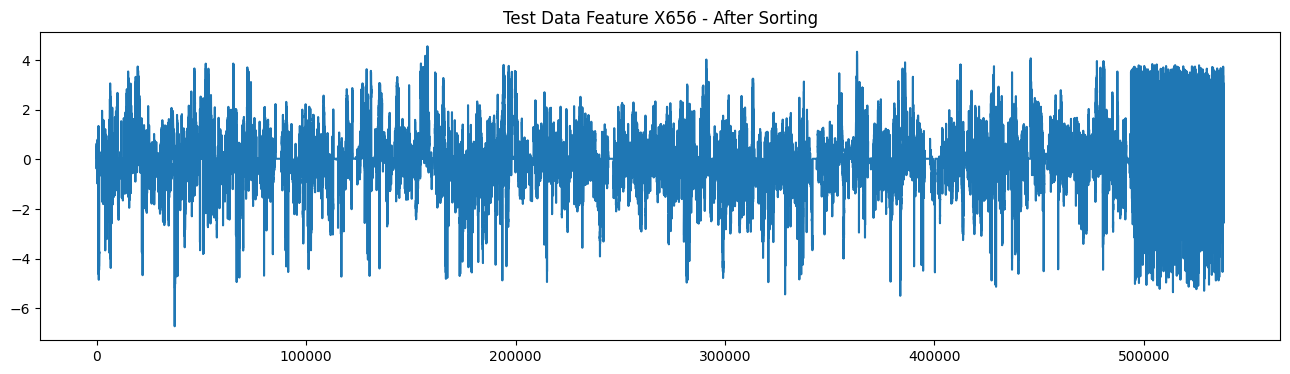


Preprocessing test data...
Using 82 features out of 82 requested
Memory usage before optimization: 172.44 MB
Memory usage after optimization: 172.44 MB
Decreased by 0.0%
Creating advanced features...
Creating feature interactions...
Creating technical indicators...
Creating lagged features in chunks...
  Processing lags: [1, 3, 5, 6, 7, 8, 9, 12, 15, 18]
  Processing lags: [20, 30, 120, 150, 365]
Memory usage before optimization: 3748.56 MB
Memory usage after optimization: 3748.56 MB
Decreased by 0.0%
Final feature count: 1824
Test data shape: (538150, 1824)

Making predictions...
  Predicting batch 1/11
  Predicting batch 2/11
  Predicting batch 3/11
  Predicting batch 4/11
  Predicting batch 5/11
  Predicting batch 6/11
  Predicting batch 7/11
  Predicting batch 8/11
  Predicting batch 9/11
  Predicting batch 10/11
  Predicting batch 11/11

Prediction statistics:
count    538150.000000
mean          0.143499
std           2.171341
min         -22.076212
25%          -0.698252
50%   

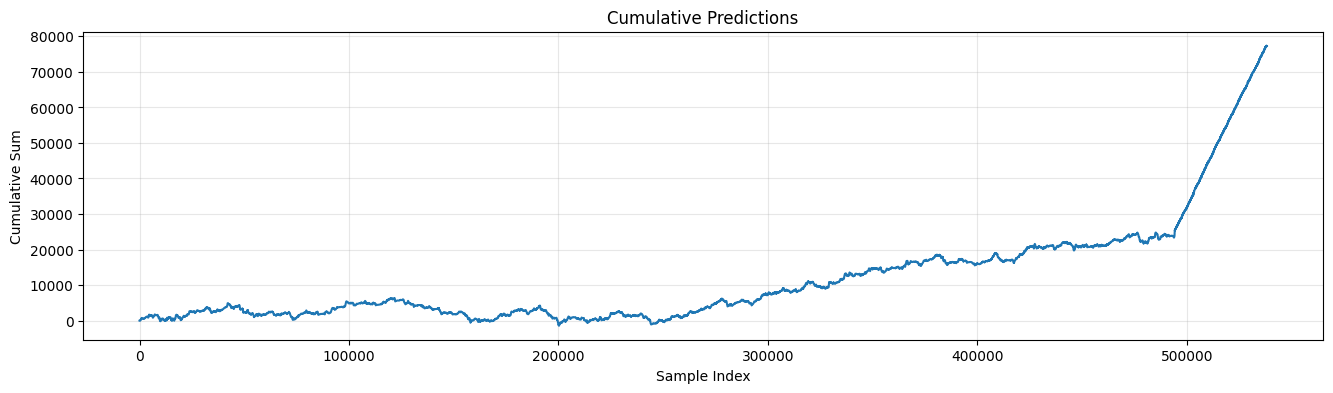

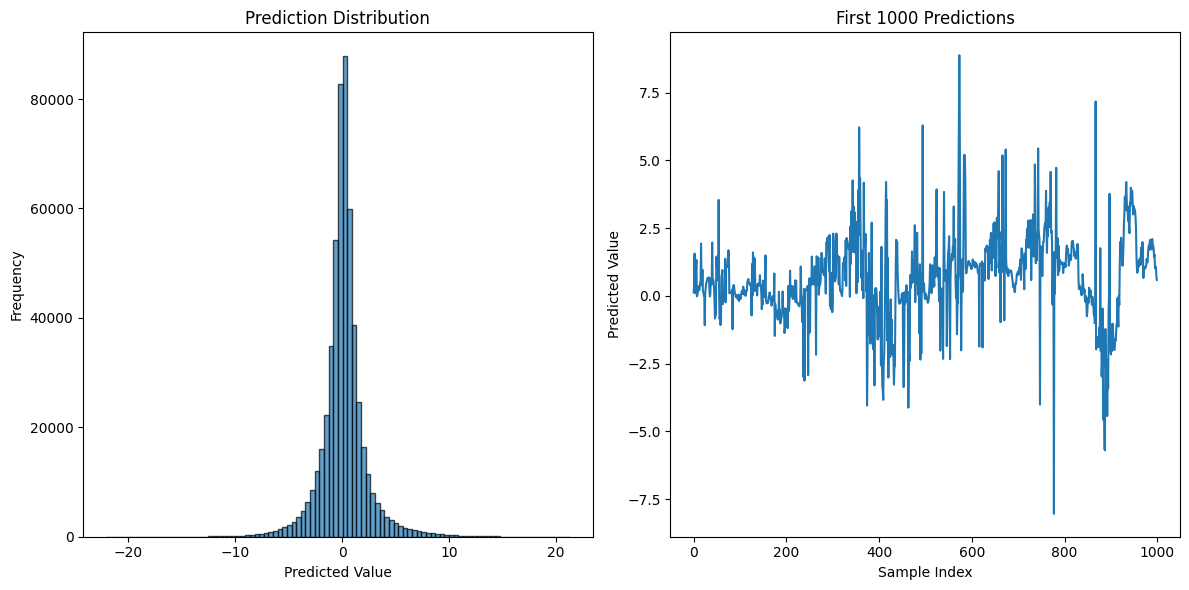


Preparing submission...
Submission saved to 'submission.csv'

Submission preview:
   ID  prediction
0   1   -0.275353
1   2    0.446726
2   3   -3.148578
3   4    0.702594
4   5    0.221033

Submission shape: (538150, 2)
Prediction range: [-22.076212, 21.297823]

Done!


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import os
import gc
import warnings
warnings.filterwarnings('ignore')


def optimize_memory(df, verbose=True):
    """
    Optimize memory usage by downcasting numeric types where possible.
    """
    if verbose:
        start_mem = df.memory_usage().sum() / 1024**2
        print(f'Memory usage before optimization: {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # For float types, we'll use float32 instead of float64
                # This is usually sufficient for ML models
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    
    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        print(f'Memory usage after optimization: {end_mem:.2f} MB')
        print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return df


def create_advanced_features(df, top_features):
    """
    Create advanced engineered features including interactions, rolling stats, and technical indicators.
    """
    print("Creating advanced features...")
    
    # Rolling statistics for top features
    windows = [5, 10, 20, 30]
    for feature in top_features[:10]:  # Only for top 10 to manage memory
        if feature in df.columns:
            for window in windows:
                # Rolling mean
                df[f'{feature}_ma_{window}'] = df[feature].rolling(window, min_periods=1).mean().astype(np.float32)
                # Rolling std (volatility)
                df[f'{feature}_vol_{window}'] = df[feature].rolling(window, min_periods=1).std().fillna(0).astype(np.float32)
                # Rolling min/max
                df[f'{feature}_min_{window}'] = df[feature].rolling(window, min_periods=1).min().astype(np.float32)
                df[f'{feature}_max_{window}'] = df[feature].rolling(window, min_periods=1).max().astype(np.float32)
    
    # Feature interactions for top features
    print("Creating feature interactions...")
    top_5_features = [f for f in top_features[:5] if f in df.columns]
    
    for i in range(len(top_5_features)):
        for j in range(i+1, len(top_5_features)):
            feat1, feat2 = top_5_features[i], top_5_features[j]
            
            # Ratio features
            df[f'{feat1}_{feat2}_ratio'] = (df[feat1] / (df[feat2].abs() + 1e-8)).astype(np.float32)
            # Difference features
            df[f'{feat1}_{feat2}_diff'] = (df[feat1] - df[feat2]).astype(np.float32)
            # Product features
            df[f'{feat1}_{feat2}_prod'] = (df[feat1] * df[feat2]).astype(np.float32)
    
    # Technical indicators
    print("Creating technical indicators...")
    for feature in top_features[:5]:
        if feature in df.columns:
            # RSI-like indicator
            delta = df[feature].diff()
            gain = delta.where(delta > 0, 0).rolling(14, min_periods=1).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(14, min_periods=1).mean()
            rs = gain / (loss + 1e-8)
            df[f'{feature}_rsi'] = (100 - (100 / (1 + rs))).astype(np.float32)
            
            # Momentum
            df[f'{feature}_momentum_5'] = (df[feature] - df[feature].shift(5)).fillna(0).astype(np.float32)
            df[f'{feature}_momentum_20'] = (df[feature] - df[feature].shift(20)).fillna(0).astype(np.float32)
    
    return df

def create_ensemble_models():
    """
    Create ensemble of different model types.
    """
    models = {
        'ridge': Ridge(alpha=1.0, copy_X=False),
        'ridge_l2': Ridge(alpha=5.0, copy_X=False),
        'xgb': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            tree_method='hist'
        )
    }
    
    return models

def validate_models_time_series(models, X, y, n_splits=3):
    """
    Validate models using time series split to avoid data leakage.
    """
    print("Performing time series cross-validation...")
    
    # Use time series split to respect temporal order
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    results = {}
    
    for name, model in models.items():
        print(f"Validating {name}...")
        scores = []
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y[train_idx]
            y_val_fold = y[val_idx]
            
            # Fit model
            model.fit(X_train_fold, y_train_fold)
            
            # Predict
            y_pred = model.predict(X_val_fold)
            
            # Calculate correlation (since that's the evaluation metric)
            correlation = np.corrcoef(y_val_fold, y_pred)[0, 1]
            scores.append(correlation)
            
            print(f"  Fold {fold+1}: Correlation = {correlation:.4f}")
        
        avg_score = np.mean(scores)
        std_score = np.std(scores)
        results[name] = {'mean': avg_score, 'std': std_score, 'scores': scores}
        
        print(f"  {name} - Mean Correlation: {avg_score:.4f} ± {std_score:.4f}")
    
    return results


def preprocess_data_chunked(raw_df, chunk_size=10, create_advanced=True, top_features=None):
    """
    Preprocess data with memory-efficient chunked lag creation and advanced features.
    """
    assert len(raw_df.shape) == 2

    y = raw_df['label'].to_numpy().astype(np.float32) if 'label' in raw_df.columns else None

    # Original features
    cols = [
        'X363', 'X405', 'X321',
        'X175', 'X179', 'X137', 'X197', 'X22', 'X40', 'X181',
        'X28', 'X169', 'X198', 'X173',
        'X338', 'X288', 'X385', 'X344', 'X427', 'X587', 'X450',
        'X97', 'X52', 'X444',
        'X598', 'X379', 'X696', 'X297', 'X138',
        'X572', 'X343', 'X586', 'X466', 'X438', 'X452', 'X459',
        'X435', 'X386', 'X55', 'X341', 'X683', 'X428', 'X605',
        'X445', 'X272', 'X180', 'X593', 'X680',
        'X686', 'X692', 'X695',
        "X603", "X674", "X421", "X333",
        "X415", "X345", "X174", "X302", "X178", "X168", "X612",
        'X298', 'X45', 'X46', 'X39', 'X752', 'X759', 'X41', 'X42',
        "buy_qty", "sell_qty", "volume",
        "bid_qty", "ask_qty",
    ]
    
    # Add new top important features
    new_features = [
        'X758', 'X296', 'X611', 'X780', 'X451', 'X25', 'X591',
    ]
    
    # Combine all features and remove duplicates while preserving order
    cols = list(dict.fromkeys(cols + new_features))
    
    # Check which features actually exist in the dataframe
    available_cols = [col for col in cols if col in raw_df.columns]
    missing_cols = [col for col in cols if col not in raw_df.columns]
    
    if missing_cols:
        print(f"Warning: The following features are not in the dataset: {missing_cols}")
    
    print(f"Using {len(available_cols)} features out of {len(cols)} requested")

    # Select and optimize base features
    df = raw_df[available_cols].copy()
    df = optimize_memory(df, verbose=True)
    assert df.isna().sum().sum() == 0

    # Create advanced features if requested
    if create_advanced and top_features is not None:
        df = create_advanced_features(df, top_features)
        df = optimize_memory(df, verbose=False)

    # Extended lag features
    lag_periods = [
        1, 3, 5, 6, 7, 8, 9,  # Very short-term (1-10)
        12, 15, 18, 20, 30,          # Short-term (12-30)
        120, 150, 365,
    ]
    
    # Process lags in chunks to manage memory
    print("Creating lagged features in chunks...")
    
    # Start with base features
    result_df = df.copy()
    
    # Process lags in chunks
    for i in range(0, len(lag_periods), chunk_size):
        chunk_lags = lag_periods[i:i+chunk_size]
        print(f"  Processing lags: {chunk_lags}")
        
        # Create lagged features for this chunk
        chunk_dfs = []
        for lag in chunk_lags:
            lagged = df.shift(-lag).add_suffix(f'_lead_{lag}')
            lagged = lagged.fillna(0.0).astype(np.float32)
            chunk_dfs.append(lagged)
        
        # Concatenate chunk
        if chunk_dfs:
            chunk_combined = pd.concat(chunk_dfs, axis=1)
            result_df = pd.concat([result_df, chunk_combined], axis=1)
            
            # Clean up
            del chunk_dfs, chunk_combined
            gc.collect()
    
    # Final optimization
    result_df = optimize_memory(result_df, verbose=True)
    
    assert 'label' not in result_df.columns
    assert raw_df.shape[0] == result_df.shape[0] and (raw_df.index == result_df.index).all()
    assert result_df.isna().sum().sum() == 0
    if y is not None:
        assert result_df.shape[0] == y.shape[0]
    
    print(f"Final feature count: {result_df.shape[1]}")
    
    return result_df, y

# Set memory-efficient options for pandas
pd.options.mode.chained_assignment = None  # Disable SettingWithCopyWarning
pd.options.display.max_columns = None

## ...existing code...
# Load and preprocess training data
print("Loading training data...")
train_df = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/train.parquet')

# Display available columns to verify feature existence
print(f"\nTotal columns in training data: {len(train_df.columns)}")
print(f"Sample columns: {list(train_df.columns[:20])}")

# Optimize memory for the raw training data
print("\nOptimizing memory for raw training data...")
train_df = optimize_memory(train_df, verbose=True)

# First pass: Get initial feature importance with simple model
print("\nFirst pass: Basic preprocessing to identify top features...")
X_train_basic, y_train = preprocess_data_chunked(train_df, chunk_size=10, create_advanced=False)

# Train basic Ridge to get feature importance
basic_model = Ridge(alpha=1.0)
basic_model.fit(X_train_basic, y_train)

# Get top features for advanced feature engineering
coef_series = pd.Series(basic_model.coef_, index=basic_model.feature_names_in_).abs().sort_values(ascending=False)
top_features = coef_series.head(20).index.tolist()

print(f"\nTop features identified: {top_features[:10]}")

# Clean up basic features
del X_train_basic, basic_model
gc.collect()

# Second pass: Create advanced features
print("\nSecond pass: Creating advanced features...")
X_train, y_train = preprocess_data_chunked(train_df, chunk_size=10, create_advanced=True, top_features=top_features)

# Clean up training dataframe
del train_df
gc.collect()

print(f"\nTraining data shape: X={X_train.shape}, y={y_train.shape}")

# Create ensemble models
models = create_ensemble_models()

# Validate models using time series cross-validation
validation_results = validate_models_time_series(models, X_train, y_train, n_splits=3)

# Select best performing models for ensemble
best_models = {}
for name, results in validation_results.items():
    if results['mean'] > 0.01:  # Only include models with positive correlation
        best_models[name] = models[name]

print(f"\nSelected models for ensemble: {list(best_models.keys())}")

# Create and train ensemble
if len(best_models) > 1:
    print("\nTraining ensemble model...")
    ensemble = VotingRegressor(list(best_models.items()))
    ensemble.fit(X_train, y_train)
    final_model = ensemble
    print("Using ensemble model")
else:
    # Fallback to best single model
    best_model_name = max(validation_results.keys(), key=lambda x: validation_results[x]['mean'])
    final_model = models[best_model_name]
    final_model.fit(X_train, y_train)
    print(f"Using single model: {best_model_name}")

# Feature importance analysis
if hasattr(final_model, 'feature_importances_'):
    # For tree-based models
    feature_importance = pd.Series(final_model.feature_importances_, index=X_train.columns)
elif hasattr(final_model, 'coef_'):
    # For linear models
    feature_importance = pd.Series(np.abs(final_model.coef_), index=X_train.columns)
elif hasattr(final_model, 'estimators_'):
    # For ensemble models, average feature importance
    importance_sum = np.zeros(X_train.shape[1])
    valid_estimators = 0
    
    for estimator in final_model.estimators_:
        if hasattr(estimator, 'feature_importances_'):
            importance_sum += estimator.feature_importances_
            valid_estimators += 1
        elif hasattr(estimator, 'coef_'):
            importance_sum += np.abs(estimator.coef_)
            valid_estimators += 1
    
    if valid_estimators > 0:
        feature_importance = pd.Series(importance_sum / valid_estimators, index=X_train.columns)
    else:
        feature_importance = pd.Series(np.ones(X_train.shape[1]), index=X_train.columns)

# Plot feature importance
feature_importance = feature_importance.sort_values(ascending=False)
top_100_features = feature_importance.head(100)

plt.figure(figsize=(12, 20))
top_100_features.sort_values().plot(kind='barh')
plt.title('Top 100 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Display top 20 features
print("\nTop 20 most important features:")
for i, (feat, importance) in enumerate(feature_importance.head(20).items(), 1):
    print(f"{i:2d}. {feat:40s} {importance:.6f}")

# Clean up training data
del X_train, y_train
gc.collect()
# ...existing code...

# Load test data
print("\nLoading test data...")
test_df = pd.read_parquet('/kaggle/input/drw-crypto-market-prediction/test.parquet')

# Optimize memory for test data
print("\nOptimizing memory for raw test data...")
test_df = optimize_memory(test_df, verbose=True)

# Try to load precomputed timestamp reconstruction data
timestamp_recon_path = '/kaggle/input/the-order-of-the-test-rows-2/closest_rows.csv'
use_timestamp_reconstruction = os.path.exists(timestamp_recon_path)

if use_timestamp_reconstruction:
    print("Found timestamp reconstruction file, loading...")
    
    # Load precomputed timestamp reconstruction data
    t = pd.Series(pd.read_csv(timestamp_recon_path)['0'].to_numpy())
    assert t.shape == (test_df.shape[0],)
    print('Reconstructed timestamps share:', len(t[t >= 0]) / len(t))

    # Visualize the reconstructed timestamps
    plt.figure(figsize=(16, 4))
    plt.plot(t.sort_values().to_numpy())
    plt.title('Sorted Reconstructed Timestamps')
    plt.show()

    plt.figure(figsize=(16, 4))
    plt.plot(t[t >= 0].sort_values().iloc[:1000].to_numpy())
    plt.axhline(10080, color='r', linestyle='--')
    plt.title('First 1000 Valid Reconstructed Timestamps')
    plt.show()

    # Process timestamp reconstruction
    t -= 10080
    t[t < 0] = 538149

    t = t.sort_values()
    t[t <= len(t)] = np.arange(t[t <= len(t)].shape[0])
    t = t.sort_index()

    t = pd.Series(np.arange(538150), index=t.to_numpy()).sort_index()

    # Visualize test data before sorting
    if 'X656' in test_df.columns:
        plt.figure(figsize=(16, 4))
        plt.plot(test_df['X656'].to_numpy())
        plt.title('Test Data Feature X656 - Before Sorting')
        plt.show()

    # Sort test dataset by reconstructed time order
    test_df = test_df.iloc[t.to_numpy()]

    # Visualize test data after sorting
    if 'X656' in test_df.columns:
        plt.figure(figsize=(16, 4))
        plt.plot(test_df['X656'].to_numpy())
        plt.title('Test Data Feature X656 - After Sorting')
        plt.show()
else:
    print("WARNING: Timestamp reconstruction file not found!")
    print(f"Expected path: {timestamp_recon_path}")
    print("Proceeding without timestamp reconstruction...")
    print("This may significantly impact model performance since lagged features assume temporal order.")
    
    t = pd.Series(np.arange(len(test_df)))

# Preprocess test data
# ...existing code for loading and timestamp reconstruction...

# Preprocess test data
print("\nPreprocessing test data...")
X_test, _ = preprocess_data_chunked(test_df, chunk_size=10, create_advanced=True, top_features=top_features)

# Clean up test dataframe
del test_df
gc.collect()

print(f"Test data shape: {X_test.shape}")

# Make predictions in batches to save memory
print("\nMaking predictions...")
batch_size = 50000  # Reduced batch size due to more features
n_samples = X_test.shape[0]
y_pred = np.zeros(n_samples, dtype=np.float32)

for i in range(0, n_samples, batch_size):
    end_idx = min(i + batch_size, n_samples)
    print(f"  Predicting batch {i//batch_size + 1}/{(n_samples + batch_size - 1)//batch_size}")
    y_pred[i:end_idx] = final_model.predict(X_test.iloc[i:end_idx]).astype(np.float32)

# ...rest of existing code...
# Clean up test features
del X_test
gc.collect()

# Display prediction statistics
print("\nPrediction statistics:")
print(pd.Series(y_pred).describe())

# Plot cumulative predictions
plt.figure(figsize=(16, 4))
plt.plot(np.cumsum(y_pred))
plt.title('Cumulative Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Cumulative Sum')
plt.grid(True, alpha=0.3)
plt.show()

# Plot prediction distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y_pred, bins=100, alpha=0.7, edgecolor='black')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(y_pred[:1000])
plt.title('First 1000 Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.tight_layout()
plt.show()

# Prepare submission
print("\nPreparing submission...")
submission = pd.read_csv('/kaggle/input/drw-crypto-market-prediction/sample_submission.csv')

if use_timestamp_reconstruction:
    # Reorder submission to match original test order
    submission = submission.iloc[t.to_numpy()]
    submission['prediction'] = y_pred
    submission = submission.sort_index()
else:
    # If no timestamp reconstruction, just use predictions in order
    submission['prediction'] = y_pred

# Save submission
submission.to_csv('submission.csv', index=False)
print("Submission saved to 'submission.csv'")

# Display submission
print("\nSubmission preview:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Prediction range: [{submission['prediction'].min():.6f}, {submission['prediction'].max():.6f}]")

# Final memory cleanup
gc.collect()
print("\nDone!")

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth  # This works in Kaggle too sometimes
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [ ]:
# Upload ZIP or CSV
upload_file = drive.CreateFile({'title': 'my_csv_backup.zip'})
upload_file.SetContentFile('/kaggle/working/my_csv_backup.zip')
upload_file.Upload()

print("✅ File uploaded to Google Drive!")
print(f"🔗 Shareable Link: https://drive.google.com/file/d/{upload_file['id']}/view?usp=sharing")


Result: 

Score: 0.72837

run time: 90min (Kaggle editor)

Rank: 31 (2025-07-14-13:15, JST)

Your Best Entry!
Your most recent submission scored 0.72837, which is an improvement of your previous score of -0.00204. Great job!

Rank 31 on #kaggle. I'll sleep when I'm dead. https://kaggle.com/competitions/drw-crypto-market-prediction 